In [1]:
import openalexnet as oanet
import pandas as pd
import igraph as ig
import numpy as np
import matplotlib as mpl
import json

import nltk
nltk.download('wordnet')

from tqdm.auto import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /home/marlon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
filterData = {
    "is_paratext": "false",  # Only works, no paratexts (https://en.wikipedia.org/wiki/Paratext)
    "type": "journal-article", # Only journal articles
    "from_publication_date": "2020-01-01" # Published after 2020
}

searchString = "\"complex network\"" # works containing the string "complex networks"
sortData = ["cited_by_count:desc"] # sort by number of citations in descending order
entityType = "works"

openalex = oanet.OpenAlexAPI()

entities = openalex.getEntities(entityType,
                                filter=filterData,
                                search=searchString,
                                sort=sortData,
                                maxEntities=2500)

In [3]:
k_DefaultKeptItems = [
    "id",
    "doi",
    "title",
    "display_name",
    "publication_year",
    "publication_date",
    "type",
    "authorships",
    "concepts",
    "host_venue",
    'abstract_inverted_index' 
]

network = oanet.createNetworks(entities,
                               networkTypes=["citation"],
                               simplifyNetworks=True,
                               keptAttributes = k_DefaultKeptItems,
                               showProgress=True)

network = network['citation']
network.summary()

Extracting edges and attributes:   0%|          | 0/2444 [00:00<?, ?it/s]

'IGRAPH D--T 2444 1852 -- \n+ attr: abstract_inverted_index (v), authorships (v), concepts (v), display_name (v), doi (v), host_venue (v), id (v), publication_date (v), publication_year (v), title (v), type (v)'

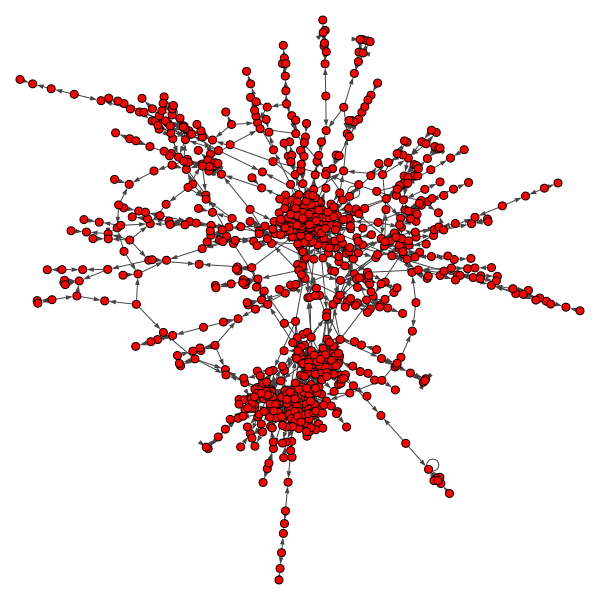

In [4]:
connected_components = network.components("weak").giant()
ig.plot(
    connected_components,
    vertex_size = 8.0,
    edge_arrow_size = 0.5
)

In [5]:
connected_components.summary()

'IGRAPH D--T 918 1643 -- \n+ attr: abstract_inverted_index (v), authorships (v), concepts (v), display_name (v), doi (v), host_venue (v), id (v), publication_date (v), publication_year (v), title (v), type (v)'

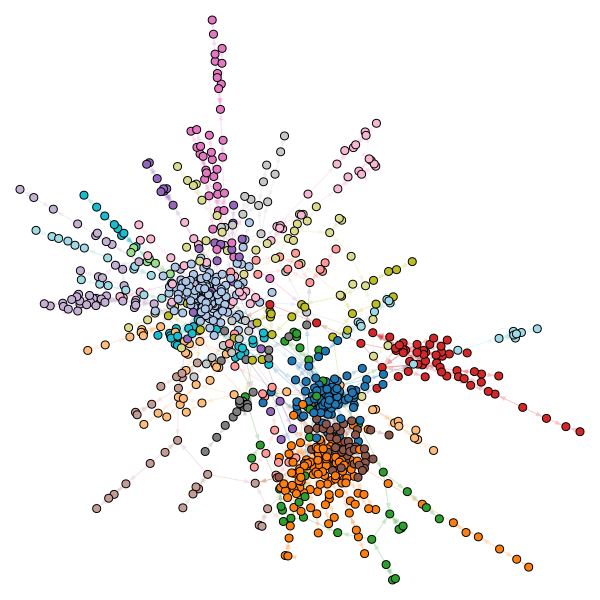

In [6]:
connected_components.vs['community'] = connected_components.as_undirected().community_multilevel().membership

vertex_colors = [mpl.cm.tab20(index) for index in connected_components.vs["community"]]
edge_colors = [vertex_colors[edge.source][:-1]+(0.25,) for edge in connected_components.es]

# labels = connected_components.vs["display_name"]

layout = connected_components.layout("fr")
ig.plot(connected_components,
        layout = layout,
#         vertex_label = labels,
#         vertex_label_size = 5,
        vertex_size = 8,
        vertex_color = vertex_colors,
        edge_arrow_size = 0.5,
        edge_color = edge_colors
        )

In [7]:
n_vertex = connected_components.vcount()
for i in tqdm(range(n_vertex)):
    if (connected_components.vs[i]['abstract_inverted_index'] == 'null'):
        continue
   
    abstract_inverted_index = json.loads(connected_components.vs[i]['abstract_inverted_index'])
    abstract_index = {}
    for k, vlist in abstract_inverted_index.items():
        for v in vlist:
            abstract_index[v] = k

    connected_components.vs[i]['abstract_inverted_index'] = ' '.join(abstract_index[k] for k in sorted(abstract_index.keys()))

  0%|          | 0/918 [00:00<?, ?it/s]

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for i in tqdm(range(n_vertex)):
    if (connected_components.vs[i]['abstract_inverted_index'] == 'null'):
        continue

    abstract = connected_components.vs[i]['abstract_inverted_index']
    
    abstract = nltk.word_tokenize(abstract)
    abstract = [word.lower() for word in abstract if word.isalpha()]
    abstract = [w for w in abstract if not w.lower() in stop_words]
    
    connected_components.vs[i]['abstract_inverted_index'] = [lemmatizer.lemmatize(w) for w in abstract]

  0%|          | 0/918 [00:00<?, ?it/s]

In [9]:
def n_grams(n_grams, connected_components, n_vertex):
    counterAll = Counter()
    countersCommunities = {}

    for i in tqdm(range(n_grams, n_vertex)):
        tokens = connected_components.vs[i]['abstract_inverted_index']
        
        community = connected_components.vs[i]['community']
        if community not in countersCommunities:
            countersCommunities[community] = Counter()
        countersCommunities[community].update(set(tokens))
        counterAll.update(set(tokens))
        
    return counterAll, countersCommunities

In [10]:
tokens = connected_components.vs[0]['abstract_inverted_index']
token = [tuple(tokens[:2]), tuple(tokens[:2])]
token[0] == token[1]

True

In [11]:
counterAll, countersCommunities = n_grams(1, connected_components, n_vertex)
print('Amount of words:', sum(counterAll.values()))
print('Amount of different words:', len(counterAll))

  0%|          | 0/917 [00:00<?, ?it/s]

Amount of words: 56149
Amount of different words: 6187


In [12]:
def alpha_communities(connected_components, communities):
    alpha_module = {}
    for c in communities:
        alpha_module[c] = connected_components.vs['community'].count(c)
    return alpha_module

In [13]:
"""
    N     = total number of papers in the network
    F_in  = relative in-community frequency
    F_out = relative out-community frequency
    I     = importance of keywords
"""

N = n_vertex
I = {}
alpha_module = alpha_communities(connected_components, countersCommunities.keys())

for community in tqdm(countersCommunities.keys()):
    I[community] = {}
    for word in countersCommunities[community].keys():
        F_in = countersCommunities[community][word] / alpha_module[community]
        F_out = (counterAll[word] - countersCommunities[community][word]) / (N - alpha_module[community])
        I[community][word] = F_in - F_out
    I[community] = dict(sorted(I[community].items(), key=lambda item: item[1], reverse=True))

  0%|          | 0/23 [00:00<?, ?it/s]

In [14]:
list(I[0].items())[0:15]

[('error', 0.5586705767350929),
 ('estimation', 0.49188660801564027),
 ('state', 0.45747800586510257),
 ('estimator', 0.438435972629521),
 ('example', 0.42475073313782985),
 ('sufficient', 0.40766373411534707),
 ('class', 0.387683284457478),
 ('gain', 0.36512218963831866),
 ('condition', 0.36144672531769306),
 ('measurement', 0.35695014662756597),
 ('bound', 0.3245356793743891),
 ('problem', 0.3049071358748778),
 ('upper', 0.3007624633431085),
 ('matrix', 0.29618768328445744),
 ('finally', 0.27781036168132944)]